In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

from trustee import ClassificationTrustee

In [2]:
pool_1_ips = {
    '169.231.210.93',
    '169.231.28.232',
    '169.231.123.195',
    '169.231.172.165',
    '169.231.11.193',
    '169.231.8.190',
    '169.231.10.199'
}

pool_2_ips = {"128.111.52.37"}

In [3]:
def read_dataset(prefix: str):
    dataset_1 = pd.read_csv(f'{prefix}_cicfeatures_1.csv')
    dataset_1['Class'] = 0
    dataset_1.loc[dataset_1['Src IP'].isin(pool_1_ips), 'Class'] = 1
    ttl_data_1 = pd.read_csv(f'{prefix}_ttl_1.csv')
    dataset_1 = dataset_1.merge(ttl_data_1, on="Flow ID", how='left')
    
    dataset_2 = pd.read_csv(f'{prefix}_cicfeatures_2.csv')
    dataset_2['Class'] = 0
    dataset_2.loc[dataset_2['Src IP'].isin(pool_2_ips), 'Class'] = 1
    ttl_data_2 = pd.read_csv(f'{prefix}_ttl_2.csv')
    dataset_2 = dataset_2.merge(ttl_data_2, on="Flow ID", how='left')
    
    dataset = pd.concat([dataset_1, dataset_2])
    dataset = dataset.replace([np.inf, -np.inf], np.nan)
    dataset = dataset.dropna(axis=0)
    dataset = dataset.drop([
        'Flow ID',
        'Src IP',
        'Dst IP',
        'Timestamp', 
        'Protocol',    # always tcp
        'Label',       # empty
    ], axis=1)
    dataset.to_csv(f'{prefix}_dataset.csv')
    return dataset

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
def train_and_visualize(dataset, clf, visualize_tree = False):
    target_variable = 'Class'
    features = list(sorted(set(dataset.columns) - {target_variable}))
    x_data = dataset[features]
    y_data = dataset[target_variable]
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)
    
    x_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x_train.columns)
    x_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns = x_test.columns)
    
    trained_clf = clf.fit(x_train, y_train)
    prediction = trained_clf.predict(x_test)
    print(metrics.classification_report(y_test, prediction))
    
    trustee = ClassificationTrustee(expert=trained_clf)
    trustee.fit(x_train, y_train, num_iter=10, num_stability_iter=3, samples_size=0.8)
    
    _, dt, _, score = trustee.explain()
    print(f"Training score of pruned DT: {score}")
    dt_y_pred = dt.predict(x_test)
    
    print("Model explanation global fidelity report:")
    print(metrics.classification_report(prediction, dt_y_pred))
    print("Model explanation score report:")
    print(metrics.classification_report(y_test, dt_y_pred))
    
    fig = plt.figure(figsize=(25,20))
    plot_tree(dt, feature_names=x_train.columns, class_names=['benign', 'attack'], filled=True, max_depth=3)

In [6]:
campus_dataset = read_dataset('campus')

              precision    recall  f1-score   support

           0       0.95      0.45      0.61      3434
           1       0.15      0.82      0.26       418

    accuracy                           0.49      3852
   macro avg       0.55      0.63      0.43      3852
weighted avg       0.87      0.49      0.57      3852

Training score of pruned DT: 1.0
Model explanation global fidelity report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60      1605
           1       0.99      0.05      0.10      2247

    accuracy                           0.45      3852
   macro avg       0.71      0.53      0.35      3852
weighted avg       0.76      0.45      0.31      3852

Model explanation score report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3434
           1       0.99      0.28      0.43       418

    accuracy                           0.92      3852
   macro avg       0.

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


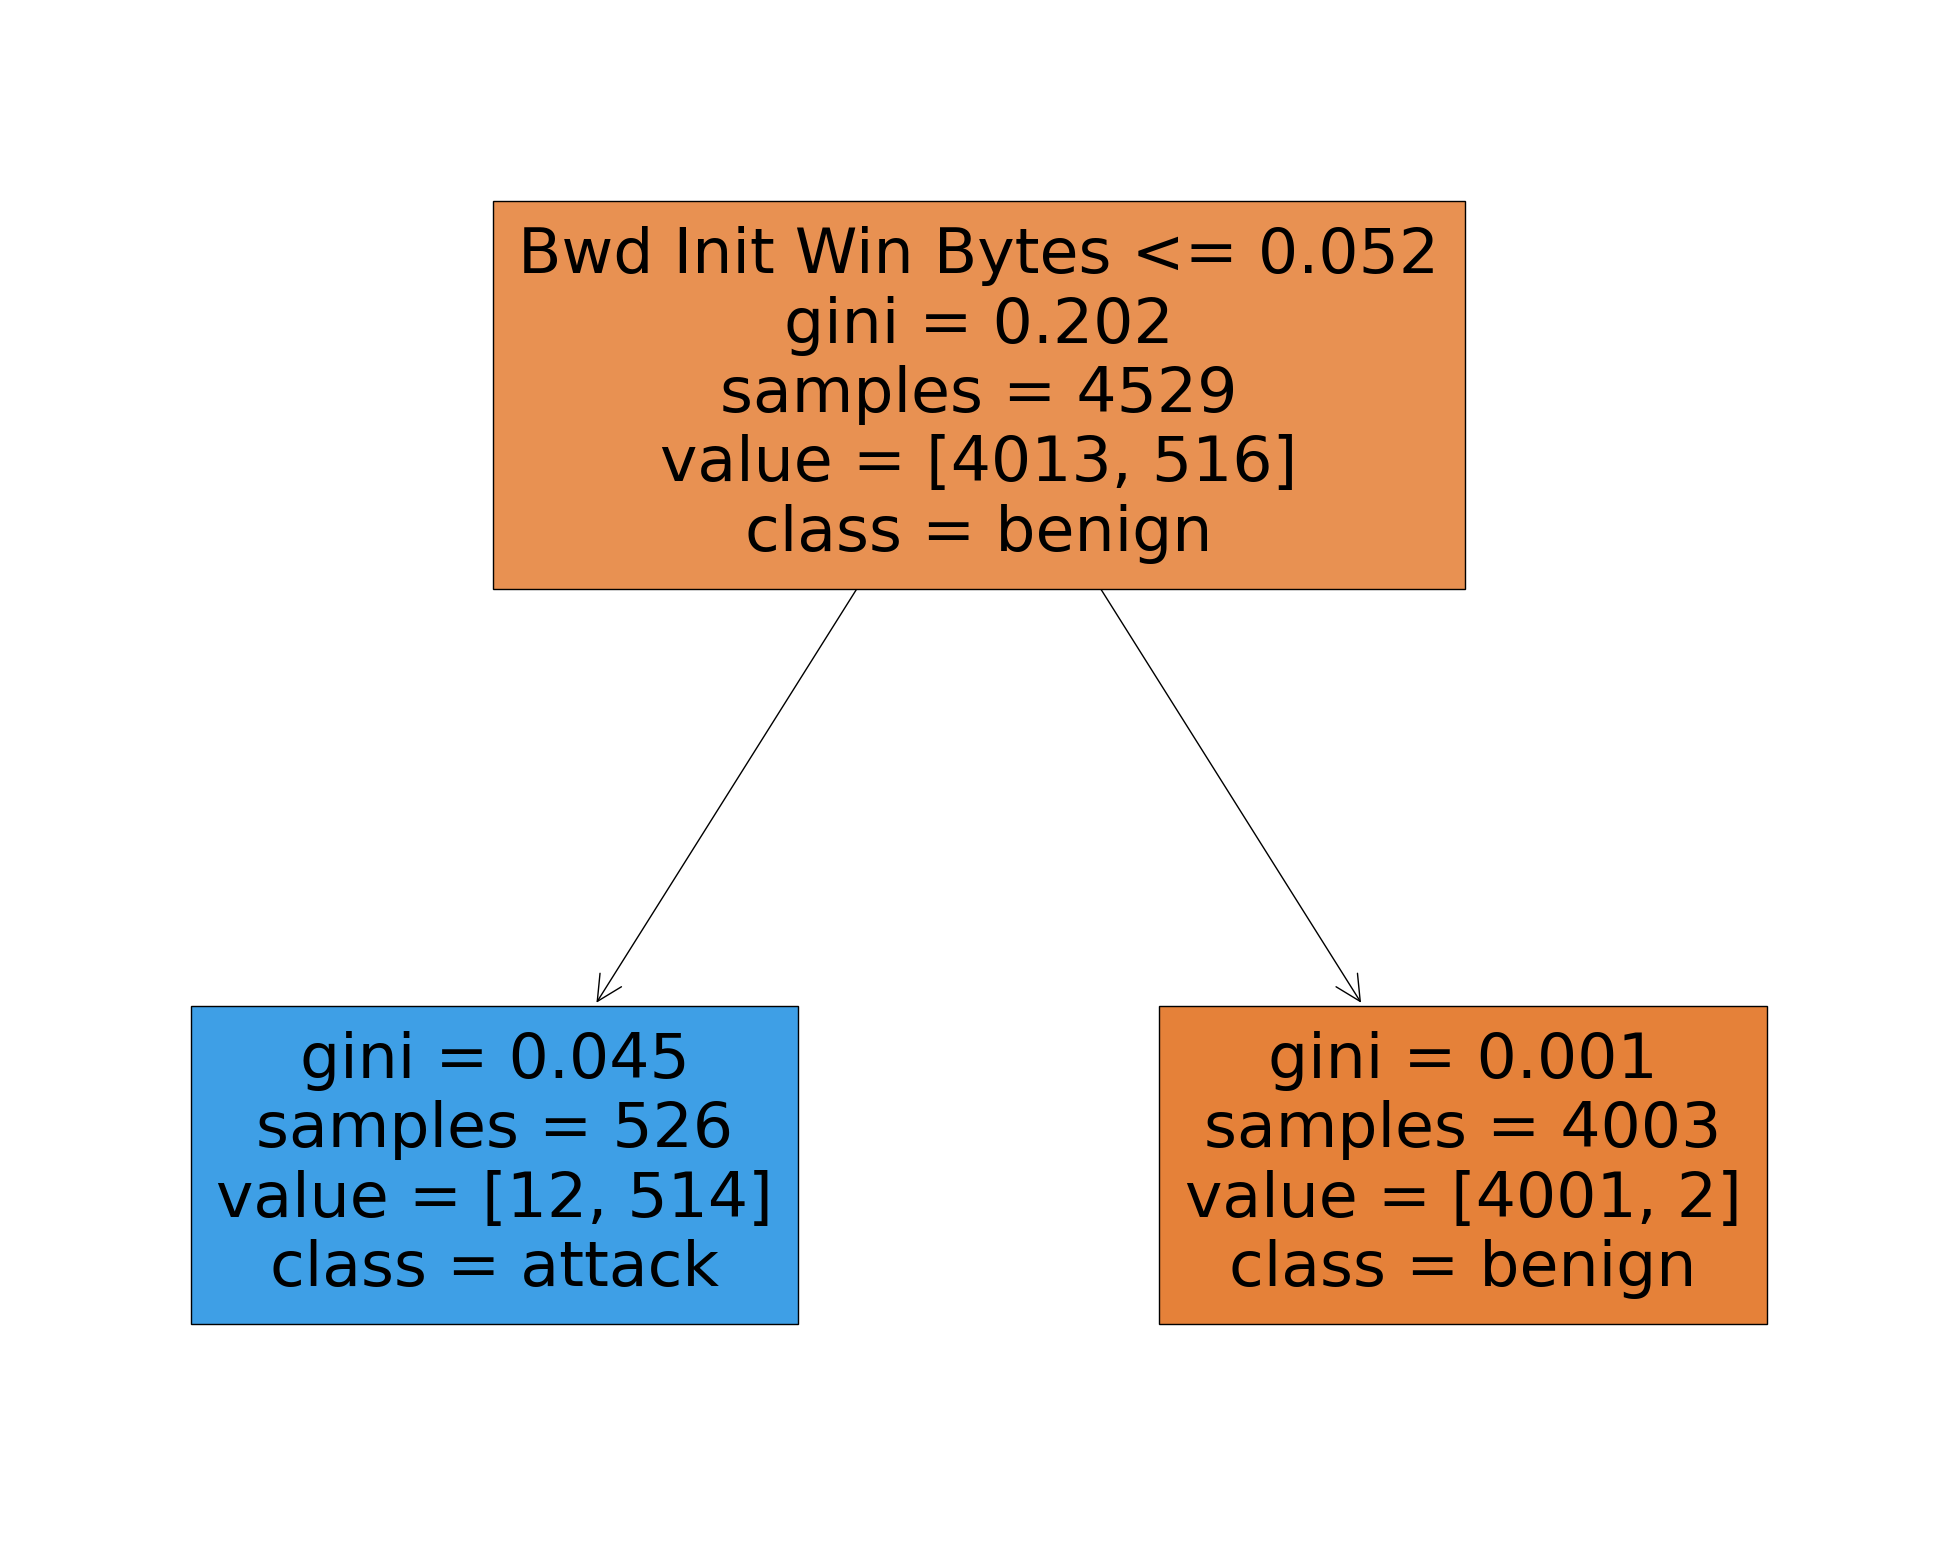

In [7]:
clf = GradientBoostingClassifier()
train_and_visualize(campus_dataset, clf)

Let's train whitebox model to double-check Trustee output due to high imbalance of classes

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3402
           1       0.81      0.31      0.45       450

    accuracy                           0.91      3852
   macro avg       0.86      0.65      0.70      3852
weighted avg       0.90      0.91      0.89      3852



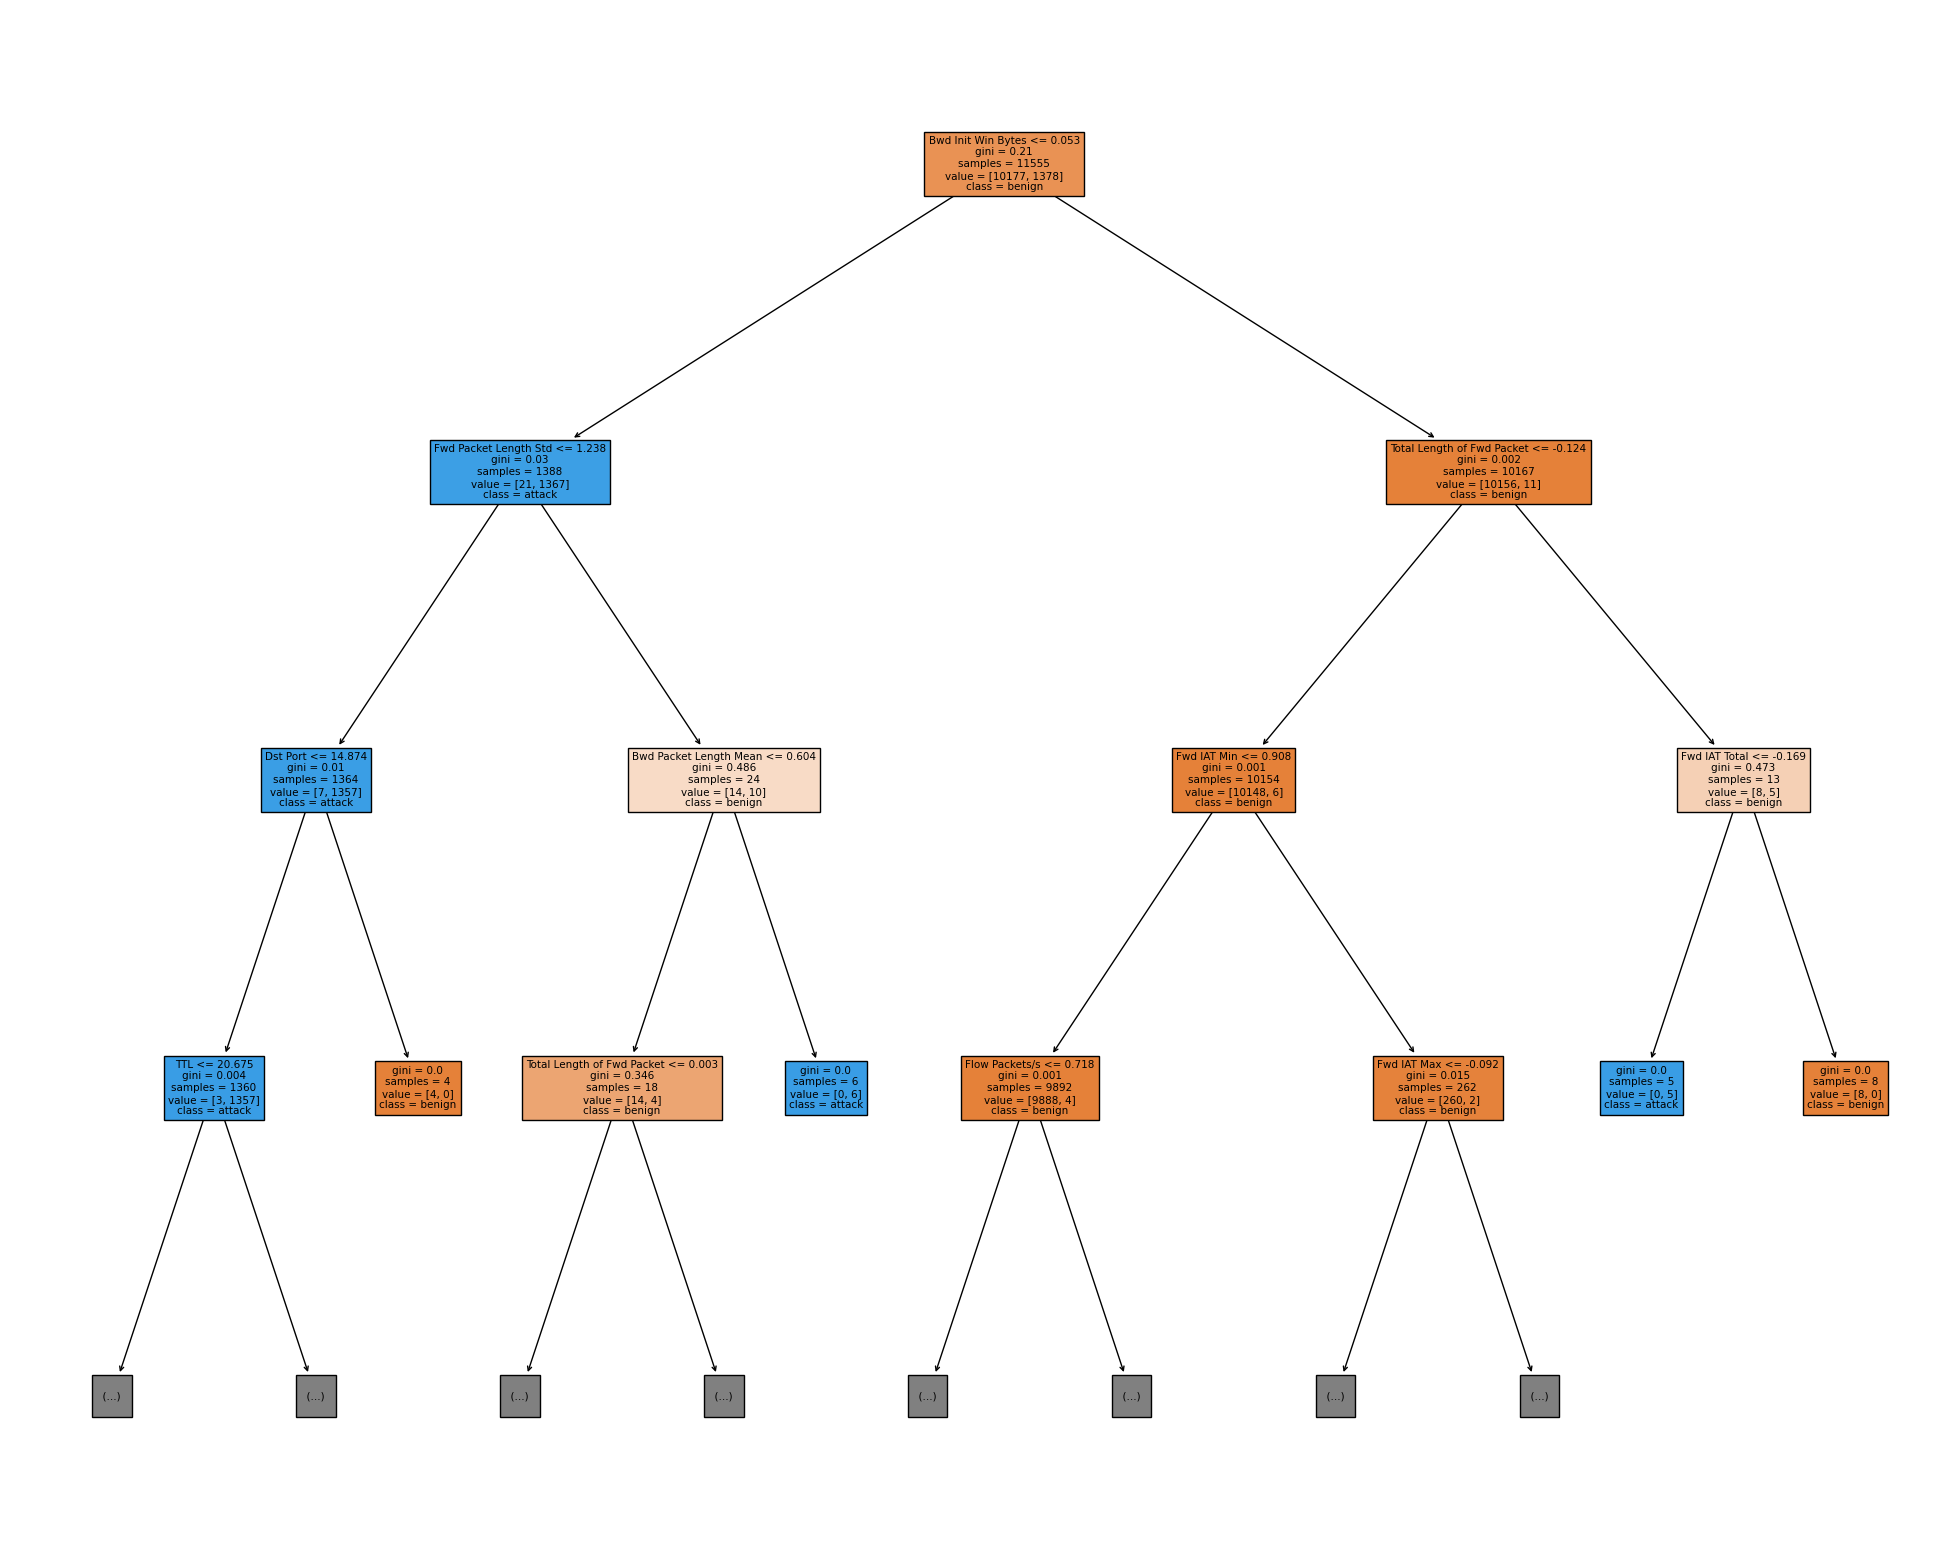

In [8]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

target_variable = 'Class'
features = list(sorted(set(campus_dataset.columns) - {target_variable}))
x_data = campus_dataset[features]
y_data = campus_dataset[target_variable]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)
x_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns = x_test.columns)
clf.fit(x_train, y_train)
prediction = clf.predict(x_test)
print(metrics.classification_report(y_test, prediction))
fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf, feature_names=x_train.columns, class_names=['benign', 'attack'], filled=True, max_depth=3)

In [9]:
azure_dataset = read_dataset('azure')

In [10]:
pool_1_ips = {
    '157.245.108.149', # netunicorn-digitalocean-1
    '34.214.149.122',  # netunicorn-aws-1
}

pool_2_ips = {
    "52.43.47.231",   # netunicorn-aws-2
    "15.164.100.10",  # netunicorn-aws-3
    "170.64.144.63",  # netunicorn-digitalocean-2
}
multicloud_dataset = read_dataset('multicloud')

In [11]:
# CIC-IDS-2018
dpath = "~/data/ids2018/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv"
cic_dataset = pd.read_csv(dpath)

In [12]:
features_rename = {
    'Fwd Pkts/b Avg': 'Fwd Packet/Bulk Avg',
    'Flow Byts/s': 'Flow Bytes/s',
    'Tot Fwd Pkts': 'Total Fwd Packet',
    'Pkt Size Avg': 'Average Packet Size',
    'Fwd Byts/b Avg': 'Fwd Bytes/Bulk Avg',
    'Fwd Pkts/s': 'Fwd Packets/s',
    'Bwd Pkt Len Max': 'Bwd Packet Length Max',
    'Fwd Header Len': 'Fwd Header Length',
    'Flow Pkts/s': 'Flow Packets/s',
    'Fwd Pkt Len Min': 'Fwd Packet Length Min',
    'RST Flag Cnt': 'RST Flag Count',
    'ECE Flag Cnt': 'ECE Flag Count',
    'Subflow Fwd Byts': 'Subflow Fwd Bytes',
    'Subflow Bwd Pkts': 'Subflow Bwd Packets',
    'TotLen Bwd Pkts': 'Total Length of Bwd Packet',
    'Bwd Header Len': 'Bwd Header Length',
    'Pkt Len Std': 'Packet Length Std',
    'Subflow Bwd Byts': 'Subflow Bwd Bytes',
    'Pkt Len Min': 'Packet Length Min',
    'TotLen Fwd Pkts': 'Total Length of Fwd Packet',
    'Pkt Len Var': 'Packet Length Variance',
    'Subflow Fwd Pkts': 'Subflow Fwd Packets',
    'Fwd Blk Rate Avg': 'Fwd Bulk Rate Avg',
    'Bwd Pkt Len Mean': 'Bwd Packet Length Mean',
    'Bwd Seg Size Avg': 'Bwd Segment Size Avg',
    'Bwd Pkts/s': 'Bwd Packets/s',
    'URG Flag Cnt': 'URG Flag Count',
    'FIN Flag Cnt': 'FIN Flag Count',
    'ACK Flag Cnt': 'ACK Flag Count',
    'Init Bwd Win Byts': 'Bwd Init Win Bytes',
    'Fwd Seg Size Avg': 'Fwd Segment Size Avg',
    'Init Fwd Win Byts': 'FWD Init Win Bytes',
    'Fwd IAT Tot': 'Fwd IAT Total',
    'Bwd Pkt Len Std': 'Bwd Packet Length Std',
    'Bwd Byts/b Avg': 'Bwd Bytes/Bulk Avg',
    'Fwd Pkt Len Std': 'Fwd Packet Length Std',
    'Pkt Len Max': 'Packet Length Max',
    'Bwd Pkt Len Min': 'Bwd Packet Length Min',
    'Tot Bwd Pkts': 'Total Bwd packets',
    'Fwd Pkt Len Max': 'Fwd Packet Length Max',
    'Bwd Pkts/b Avg': 'Bwd Packet/Bulk Avg',
    'Fwd Pkt Len Mean': 'Fwd Packet Length Mean',
    'PSH Flag Cnt': 'PSH Flag Count',
    'Bwd IAT Tot': 'Bwd IAT Total',
    'SYN Flag Cnt': 'SYN Flag Count',
    'Pkt Len Mean': 'Packet Length Mean',
    'Bwd Blk Rate Avg': 'Bwd Bulk Rate Avg',
    'CWE Flag Count': 'CWR Flag Count',
}

In [13]:
cic_dataset = cic_dataset.rename({x: features_rename.get(x.strip(), x.strip()) for x in cic_dataset.columns}, axis=1)
cic_dataset['Src Port'] = np.random.randint(20000, 40000, cic_dataset.shape[0])
cic_dataset['TTL'] = np.random.randint(60, 64, cic_dataset.shape[0])

cic_dataset['Class'] = 0
cic_dataset.loc[cic_dataset['Label'] != 'Benign', 'Class'] = 1

cic_dataset = cic_dataset.replace([np.inf, -np.inf], np.nan)
cic_dataset = cic_dataset.dropna(axis=0)

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [15]:
target_variable = 'Class'
features = list(set(campus_dataset.columns) - {target_variable})

In [16]:
x_train = campus_dataset[features]
y_train = campus_dataset[target_variable]
x_test = azure_dataset[features]
y_test = azure_dataset[target_variable]
x_test_2 = multicloud_dataset[features]
y_test_2 = multicloud_dataset[target_variable]
x_test_3 = cic_dataset[features]
y_test_3 = cic_dataset[target_variable]

In [17]:
x_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns = x_test.columns)
x_test_2 = pd.DataFrame(StandardScaler().fit_transform(x_test_2), columns = x_test_2.columns)
x_test_3 = pd.DataFrame(StandardScaler().fit_transform(x_test_3), columns = x_test_3.columns)

In [18]:
classifiers = [
    MLPClassifier(alpha=1, max_iter=100),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
]

In [19]:
for clf in classifiers:
    print(clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_train, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    
    print("CIC-IDS-2018 dataset test accuracy: ")
    y_pred = clf.predict(x_test_3)
    print(metrics.classification_report(y_test_3, y_pred))
    print(metrics.confusion_matrix(y_test_3, y_pred))
    print('#' * 10 + '\n')

MLPClassifier(alpha=1, max_iter=100)
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     13579
           1       1.00      0.77      0.87      1828

    accuracy                           0.97     15407
   macro avg       0.98      0.88      0.93     15407
weighted avg       0.97      0.97      0.97     15407

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.43      0.99      0.60     10469
           1       0.96      0.15      0.26     16083

    accuracy                           0.48     26552
   macro avg       0.70      0.57      0.43     26552
weighted avg       0.75      0.48      0.40     26552

[[10380    89]
 [13646  2437]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11164
           1       0.97      0.96      0.96      2027

    accuracy  

Training score of pruned DT: 0.9971909307627814
Model explanation global fidelity report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9712
           1       0.98      0.97      0.98      3479

    accuracy                           0.99     13191
   macro avg       0.98      0.98      0.98     13191
weighted avg       0.99      0.99      0.99     13191

Model explanation score report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     11164
           1       0.57      0.97      0.72      2027

    accuracy                           0.88     13191
   macro avg       0.78      0.92      0.82     13191
weighted avg       0.93      0.88      0.89     13191



/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


[Text(0.3333333333333333, 0.9, 'Fwd Header Length <= -0.229\ngini = 0.393\nsamples = 5170\nvalue = [3783, 1387]\nclass = benign'),
 Text(0.16666666666666666, 0.7, 'gini = 0.021\nsamples = 3422\nvalue = [3386, 36]\nclass = benign'),
 Text(0.5, 0.7, 'Src Port <= 0.121\ngini = 0.351\nsamples = 1748\nvalue = [397, 1351]\nclass = attack'),
 Text(0.3333333333333333, 0.5, 'gini = 0.029\nsamples = 1028\nvalue = [15, 1013]\nclass = attack'),
 Text(0.6666666666666666, 0.5, 'Bwd Header Length <= -0.26\ngini = 0.498\nsamples = 720\nvalue = [382, 338]\nclass = benign'),
 Text(0.5, 0.3, 'Src Port <= 1.556\ngini = 0.112\nsamples = 404\nvalue = [380, 24]\nclass = benign'),
 Text(0.3333333333333333, 0.1, '\n  (...)  \n'),
 Text(0.6666666666666666, 0.1, '\n  (...)  \n'),
 Text(0.8333333333333334, 0.3, 'gini = 0.013\nsamples = 316\nvalue = [2, 314]\nclass = attack')]

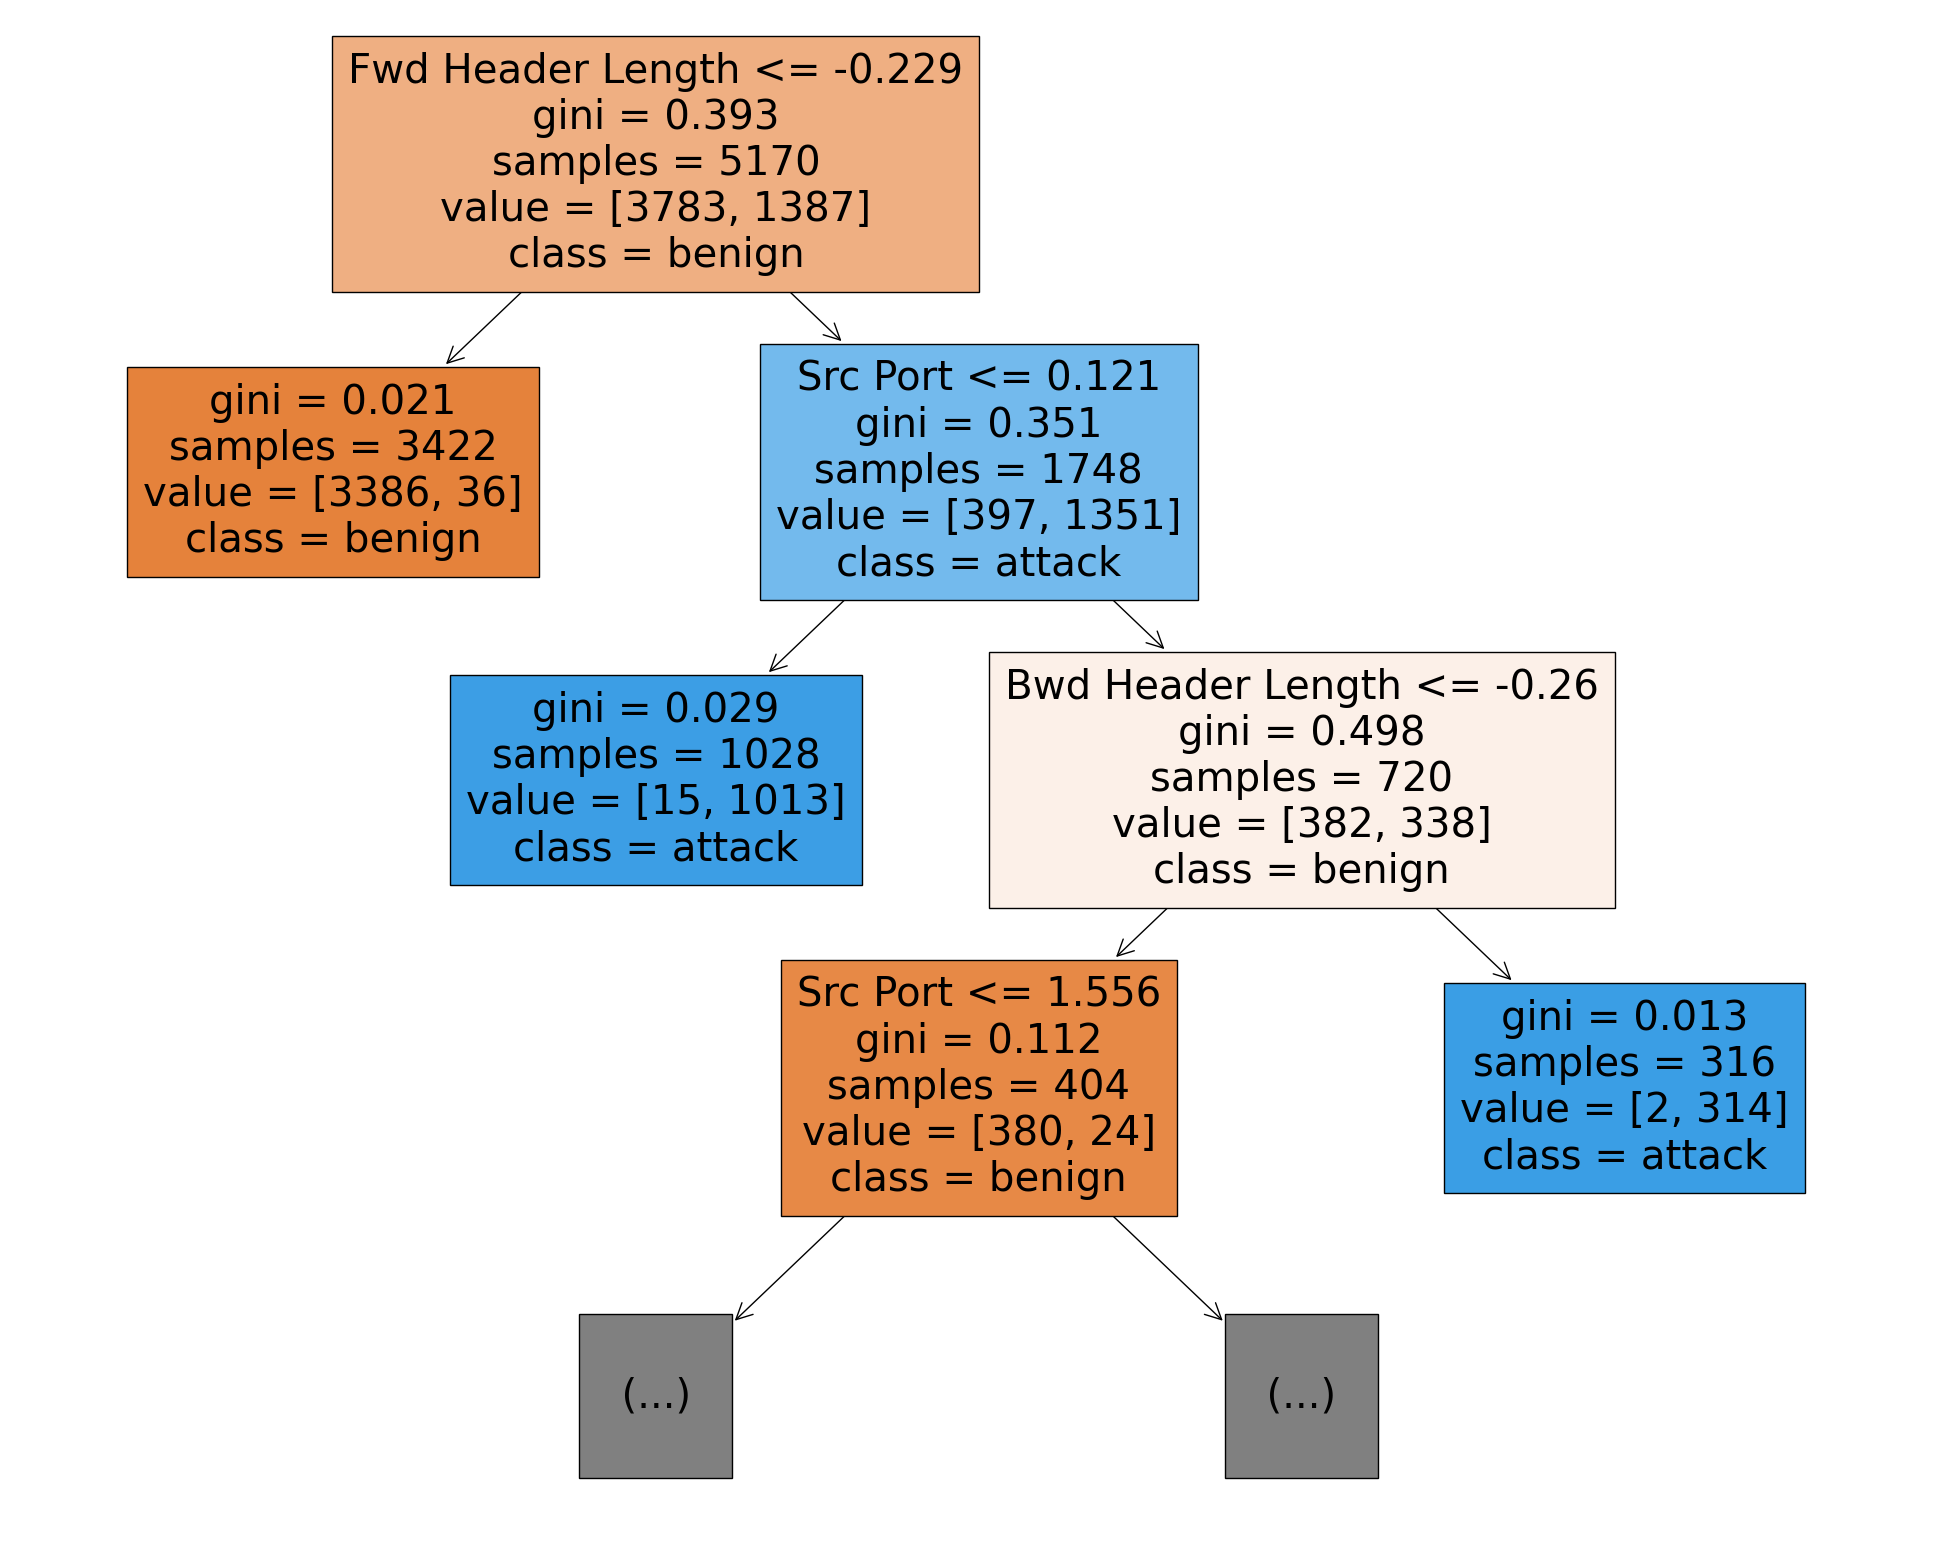

In [20]:
trustee = ClassificationTrustee(expert=clf)
trustee.fit(x_test_2, y_test_2, num_iter=10, num_stability_iter=3, samples_size=0.8)

_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")
dt_y_pred = dt.predict(x_test_2)

prediction = clf.predict(x_test_2)
print("Model explanation global fidelity report:")
print(metrics.classification_report(prediction, dt_y_pred))
print("Model explanation score report:")
print(metrics.classification_report(y_test_2, dt_y_pred))

fig = plt.figure(figsize=(25,20))
plot_tree(dt, feature_names=x_test_2.columns, class_names=['benign', 'attack'], filled=True, max_depth=3)